TEST

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import trange
from copy import deepcopy

% matplotlib inline


In [0]:
torch.manual_seed(42);

In [0]:
mnist_data = torchvision.datasets.MNIST('./', 
                                        download=True, 
                                        transform=torchvision.transforms.ToTensor());

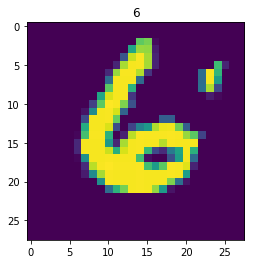

In [0]:
i = np.random.choice(range(50000))
img = torchvision.transforms.functional.to_pil_image(mnist_data[i][0])
label = mnist_data[i][1]

plt.figure()
plt.imshow(img)
plt.title(label)
plt.show()

In [0]:
BATCH_SIZE = 100

train_data, val_data = torch.utils.data.random_split(mnist_data, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True
                                          )

val_loader = torch.utils.data.DataLoader(val_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

test_mnist = torchvision.datasets.MNIST('./', download=True, train=False, transform=torchvision.transforms.ToTensor())
# test set 
test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=BATCH_SIZE, shuffle=True)
# 1-element batches for visualization
vis_loader = torch.utils.data.DataLoader(test_mnist, batch_size=1, shuffle=True)

In [0]:
def req_grad(model, state=True):
    """
    Detaches all parameters of the given model
    """
    for param in model.parameters():
        param.requires_grad_(state)

        
def plotter(x, x_adv, label, pred, pred_adv, method, noise=None):
    """
    Plots image, its adversarial perturbation, difference between then and added noise
    """ 
    
#     noise = x_adv - x
    img_noise = torchvision.transforms.functional.to_pil_image((x_adv - x).squeeze())
    x_adv = (x_adv - x_adv.min())/(x_adv.max() - x_adv.min())
    img_diff = torchvision.transforms.functional.to_pil_image((x_adv - x).squeeze())
    
    img = torchvision.transforms.functional.to_pil_image(x.squeeze())
    img_adv = torchvision.transforms.functional.to_pil_image(x_adv.squeeze())
    title_1 = "label: {} | pred: {}".format(label.item(), pred.item())
    title_2 = "label: {} | adversarial: {}".format(label.item(), pred_adv.item())
    
    plt.figure(figsize=(10,12))
    # original image
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title(title_1)
    # adversarial 
    plt.subplot(1, 4, 2)
    plt.imshow(img_adv, cmap='gray')
    plt.title(title_2)
    # image diff
    plt.subplot(1, 4, 3)
    plt.imshow(img_diff, cmap='gray')
    plt.title('image diference')
    # noise
    plt.subplot(1, 4, 4)
    plt.imshow(img_noise, cmap='gray')
    plt.title('rorshah test')
        
    plt.show()
    

In [0]:
def train(model, loader, loss, opt, train_hist, train_accuracy, verbose=True):
    model.train()
    N = 0
    for imgs, labels in loader:
        N += 1
        
        logits = model(imgs.cuda())
        predictions = (logits.data.max(1)[1]).detach().cpu()
        
        train_loss = loss(logits, labels.cuda())
        train_loss.backward()
        
        opt.step()
        opt.zero_grad()
        
        train_hist.append(train_loss.detach().cpu().item())
        train_accuracy.append(np.mean((predictions == labels).numpy()))
    
    if verbose:
        print('training   loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(train_hist[-1-N:-1]),
                                                                   np.mean(train_accuracy[-1-N:-1]) * 100))
        
    
def validation(model, loader, loss, opt, val_hist, val_accuracy, verbose=True):

    model.eval()
    
    N = 0
    for val_imgs, val_lab in loader:
        N += 1
        logits = model(val_imgs.cuda())
        preds = (logits.data.max(1)[1]).detach().cpu()
        
        val_loss = loss(logits, val_lab.cuda())
        val_hist.append(val_loss.cpu().item())
        
        val_acc_value = np.mean((preds == val_lab).numpy())
        val_accuracy.append(val_acc_value)
        
    if verbose:
        print('validation loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(val_hist[-1-N:-1]),
                                                            np.mean(val_accuracy[-1-N:-1]) * 100))  

In [0]:
def test_on_adv(model, loader, loss, params, method='fgsm', verbose=True, isplot=False, ismean=True, n_images=10):
    
    if isplot and loader.batch_size > 1:
        print('Can visualize only batches of size 1')
        isplot = False
       
    model.eval()
    loss_hist = []
    acc_hist = []
    
    loss_adv_hist = []
    acc_adv_hist = []
    
    req_grad(model, state=False) # detach all model's parameters

    N = 0
    for x, label in loader:

        N += 1
        x_adv = torch.clone(x)
        x_adv.requires_grad = True
        
        # prediction for original input 
        logits = model(x_adv.cuda())
        preds = (logits.data.max(1)[1]).detach().cpu()
        
        loss_val = loss(logits, label.cuda())
        loss_val.backward()
        
        x_adv.data = x_adv.data + params['eps'] * torch.sign(x_adv.grad.data)
        
        # perturbations
        if method == 'fgsm':
            steps = 0
            noise = params['eps'] * torch.sign(x_adv.grad.data)
            
        elif method == 'pgd':
            steps = params['steps'] - 1
            x_adv.data = torch.max(x-params['eps'], torch.min(x_adv.data, x+params['eps'])) # clipping to (x-eps; x+eps)
            
        logits_adv = model(x_adv.cuda())
        loss_adv = loss(logits_adv, label.cuda())
        loss_adv.backward()
        
        for k in range(steps):
            x_adv.data = x_adv.data + params['alpha'] * torch.sign(x_adv.grad.data)
            x_adv.data = torch.max(x-params['eps'], torch.min(x_adv.data, x+params['eps'])) # clipping to (x-eps; x+eps)

            logits_adv = model(x_adv.cuda())
            loss_adv = loss(logits_adv, label.cuda())
            loss_adv.backward()
            
        # predictions for adversarials 
        preds_adv = (logits_adv.data.max(1)[1]).detach().cpu()

        # accuracy
        acc_val = np.mean((preds == label).numpy())
        acc_adv = np.mean((preds_adv == label).numpy())

        loss_hist.append(loss_val.cpu().item())
        acc_hist.append(acc_val)
        
        loss_adv_hist.append(loss_adv.cpu().item())
        acc_adv_hist.append(acc_adv)
        
        if verbose:
            print('Batch', N)
            print('true      | loss: {:.2f} | accuracy: {:.2f}'.format(loss_val, acc_val * 100))
            print('perturbed | loss: {:.2f} | accuracy: {:.2f}%'.format(loss_adv, acc_adv * 100))
            
        if isplot:
            plotter(x, x_adv, label, preds, preds_adv, method)
            if N >= n_images: break
                
    
    if ismean:
        print('Loss: true x: {:.2f} | adversarial: {:.2f}'.format(np.mean(loss_hist), np.mean(loss_adv_hist)) )
        print('Accuracy: true x: {:.2f} | adversarial: {:.2f}'.format(np.mean(acc_hist) * 100, np.mean(acc_adv_hist) * 100))

            
    return (loss_hist, loss_adv_hist), (acc_hist, acc_adv_hist)

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)

    
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # define the architecture
        # MB DECREASE THE NUMBER OF PARAMETERS 
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        
        self.flat = Flatten()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
        self.mpool = nn.MaxPool2d(2)
        self.softmax = nn.Softmax(dim=1)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.layers = nn.Sequential(
#             self.conv1,
#             self.relu,
#             self.mpool,
#             self.conv2,
#             self.relu,
#             self.mpool,
            
            self.flat,
            self.fc1,
            self.relu,
            self.fc2,
            self.relu,
            self.fc3
#             self.softmax
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

### Train the model for MNIST

In [0]:
model = Net().cuda()
adam_opt = torch.optim.Adam(model.parameters(), lr=1e-4)
ce_loss = nn.CrossEntropyLoss()

# TEST THE MODEL
# test_x = torch.randn((batch_size,1, 28, 28))
# test_out = model(test_x.cuda())
# del test_x, test_out

In [0]:
epochs = 25

train_hist = []
train_accuracy = []

val_hist = []
val_accuracy = []

for epoch in range(epochs):
    print('epoch', epoch+1)
    
        
    train(model, train_loader, ce_loss, adam_opt, train_hist, train_accuracy, verbose=True)
    
    validation(model, val_loader, ce_loss, adam_opt, val_hist, val_accuracy, verbose=True)

### Test the model on adversarial examples

In [0]:
# parameters for adversarials

fgsm_params = {'eps': 0.05}
pgd_params = {'eps' : 0.15, 'steps' : 10, 'alpha' : 1}

In [0]:
# accuracy on adversarial batches from test set

loss_hist, accuracy_hist = test_on_adv(model, test_loader, ce_loss, fgsm_params, method='fgsm', ismean=True, verbose=False)

# loss_his, accuracy = test_on_adv(model, vis_loader, ce_loss, pdg_params, method='pdg', verbose=True)

Loss: true x: 0.07 | adversarial: 7.55
Accuracy: true x: 97.80 | adversarial: 9.67


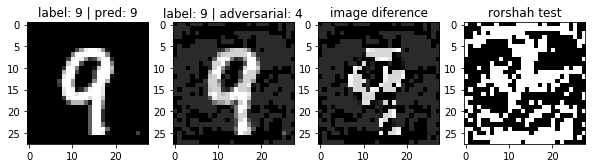

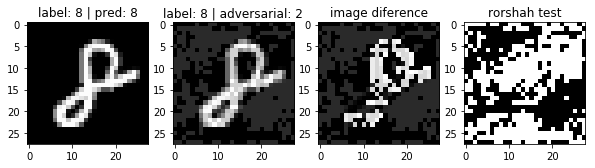

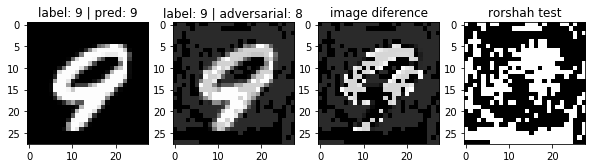

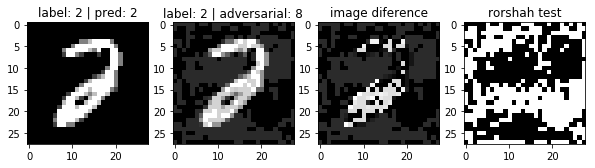

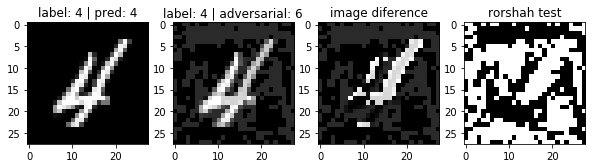

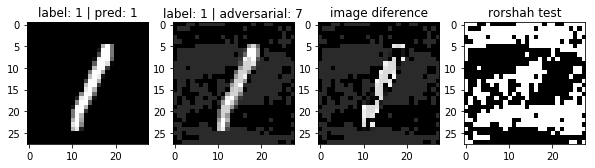

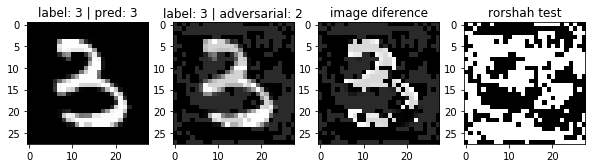

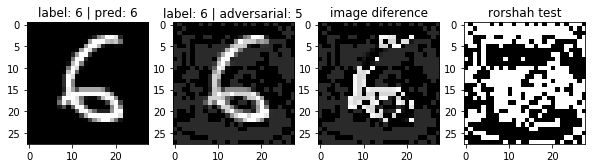

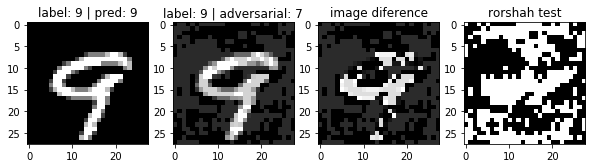

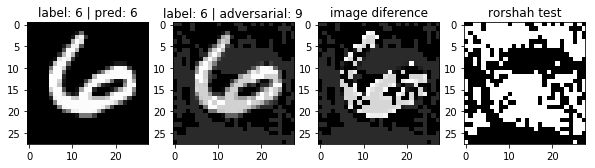

In [0]:
# visualization on data from test set

history, accuracy = test_on_adv(model, vis_loader, ce_loss, fgsm_params, method='fgsm', verbose=False, isplot=True, n_images=10)
# history, accuracy = test_on_adv(model, vis_loader, ce_loss, pgd_params, method='pgd', verbose=False, isplot=True)

### IBP

In [0]:
def compute_bounds(model, x, eps):
    """
    Computes lower and upper bounds for z_k as equation (6) in 
    
        https://arxiv.org/abs/1810.12715
        
    """
    bounds = []
    
    # if we have convolutional layers we need to reshape input to flat vectors before FC layers 
    
    bounds.append((x.view(x.shape[0], -1) - eps, x.view(x.shape[0], -1) + eps)) # reshaping to flat vectors
#     z0_low = x - model.eps
#     z0_up = x + model.eps
    
#     k = 1
    for layer in model.layers:
        
        z_l_prev, z_u_prev = bounds[-1]
        
        if isinstance(layer, Flatten):
            z_l = Flatten()(z_l_prev)
            z_u = Flatten()(z_u_prev)
            
            bounds.append((z_l, z_u))
        
        if isinstance(layer, nn.Linear):
            W = layer.weight
            b = layer.bias

            m = (z_u_prev + z_l_prev) / 2
            r = (z_u_prev - z_l_prev) / 2

            m = torch.matmul(m, W.t()) + b
            r = torch.matmul(r, torch.abs(W.t()))

            z_l = m - r
            z_u = m + r
            bounds.append((z_l, z_u))
#             k += 1
            
        elif isinstance(layer, nn.Conv2d):
            
            continue 
            
            W = layer.weight
            b = layer.bias
#             z_l_prev, z_u_prev = bounds[-1]

            m = (z_u_prev + z_l_prev) / 2
            r = (z_u_prev - z_l_prev) / 2

            # this part should be rewritten with F.conv...
#             m = torch.matmul(m, W.t()) + b
#             r = torch.matmul(r, torch.abs(W.t()))

            z_l = m - r
            z_u = m + r
            bounds.append((z_l, z_u))
#             k += 1

        elif isinstance(layer, nn.ReLU):
            
            z_l = torch.relu(z_l_prev)
            z_u = torch.relu(z_u_prev)
            
            bounds.append((z_l, z_u))
        
        else: 
            continue
        
    return bounds

In [0]:
def ibp_loss(base_loss, logits, z_k, y, k=0.5):

    e_y = torch.zeros((1, logits.shape[1])).to('cuda')
    e_y[:, y] = 1
    z_hat =  e_y * z_k[0] + (1 - e_y) * z_k[1]
    
    L_spec = base_loss(z_hat, y)
    L_fit = base_loss(logits, y)
    
    L = k * L_fit + (1 - k) * L_spec
    
    return L, L_spec, L_fit

### IBP training

In [0]:
def ibp_train(model, loader, base_loss, loss, opt, compute_bounds, eps, k, train_hist, train_accuracy,  verbose=True):
    N = 0
    L_spec_hist = []
    L_fit_hist = []
    
    for imgs, labels in loader:
        N += 1

        logits = model(imgs.cuda())
        predictions = (logits.data.max(1)[1]).detach().cpu()
        bounds = compute_bounds(model, imgs.cuda(), eps)
        z_k = bounds[-1]


        train_loss, L_spec, L_fit = loss(base_loss, logits, z_k, labels.cuda(), k)
        train_loss.backward()

        opt.step()
        opt.zero_grad()

        train_hist.append(train_loss.detach().cpu().item())
        train_accuracy.append(np.mean((predictions == labels).numpy()))
        
        L_spec_hist.append(L_spec.detach().cpu().item())
        L_fit_hist.append(L_fit.detach().cpu().item())
        

    if verbose:
        print('training   loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(train_hist[-1-N:-1]),
                                                                       np.mean(train_accuracy[-1-N:-1]) * 100))
        
        print('L_spec: {:.2f} | L_fit: {:.2f}'.format(np.mean(L_spec_hist[-1-N:-1]), np.mean(L_fit_hist[-1-N:-1])) )
        
        
        



In [0]:
verbose = True
epochs = 10
base_loss = nn.CrossEntropyLoss()

ibp_train_hist = []
ibp_train_acc = []

ibp_val_hist = []
ibp_val_acc = []

ibp_model = Net().cuda()
ibp_opt = torch.optim.Adam(ibp_model.parameters(), lr=1e-3)

eps = 0.1
k = 0.5

In [0]:
for epoch in range(epochs):
    
    print('epoch:', epoch+1)
    
    ibp_train(ibp_model, train_loader, base_loss, ibp_loss, ibp_opt, compute_bounds, eps, k, ibp_train_hist, ibp_train_acc,  verbose=True)
    
    validation(ibp_model, val_loader, base_loss, ibp_opt, ibp_val_hist, ibp_val_acc, verbose=True)
    
    

epoch: 1
training   loss: 0.51 | accuracy: 86.03%
L_spec: 0.57 | L_fit: 0.45
validation loss: 0.18 | accuracy: 94.71%
epoch: 2
training   loss: 0.17 | accuracy: 96.15%
L_spec: 0.21 | L_fit: 0.13
validation loss: 0.12 | accuracy: 96.36%
epoch: 3
training   loss: 0.12 | accuracy: 97.33%
L_spec: 0.15 | L_fit: 0.09
validation loss: 0.09 | accuracy: 97.13%
epoch: 4
training   loss: 0.22 | accuracy: 97.87%
L_spec: 0.34 | L_fit: 0.09
validation loss: 0.18 | accuracy: 95.43%
epoch: 5
training   loss: 0.09 | accuracy: 97.76%
L_spec: 0.11 | L_fit: 0.08
validation loss: 0.09 | accuracy: 97.39%
epoch: 6
training   loss: 0.07 | accuracy: 98.57%
L_spec: 0.08 | L_fit: 0.05
validation loss: 0.08 | accuracy: 97.52%
epoch: 7
training   loss: 0.22 | accuracy: 98.20%
L_spec: 0.36 | L_fit: 0.07
validation loss: 0.09 | accuracy: 97.27%
epoch: 8
training   loss: 0.06 | accuracy: 98.72%
L_spec: 0.07 | L_fit: 0.05
validation loss: 0.08 | accuracy: 97.56%
epoch: 9
training   loss: 0.05 | accuracy: 99.12%
L_spec

Loss: true x: 0.07 | adversarial: 1.24
Accuracy: true x: 97.87 | adversarial: 67.99


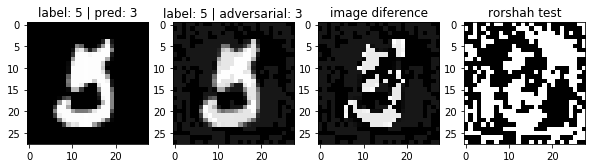

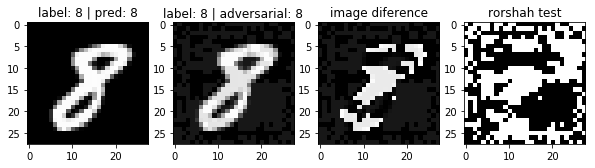

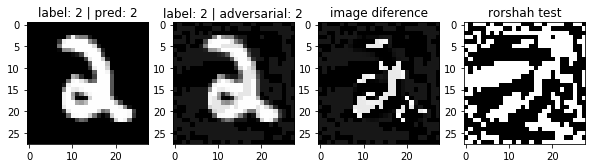

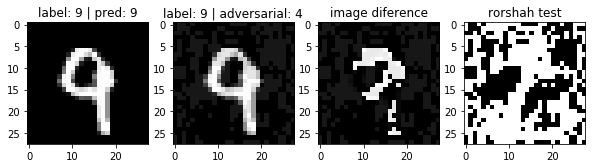

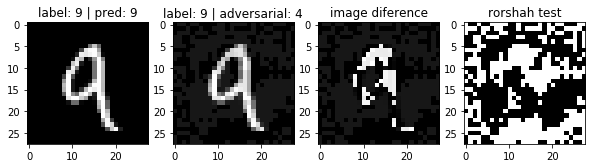

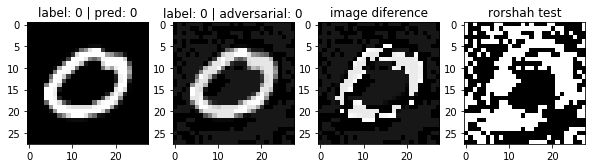

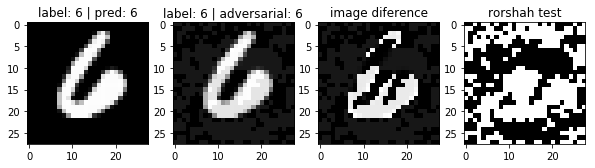

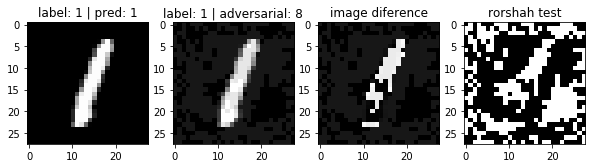

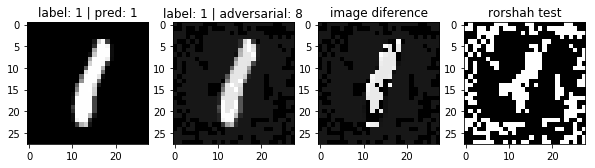

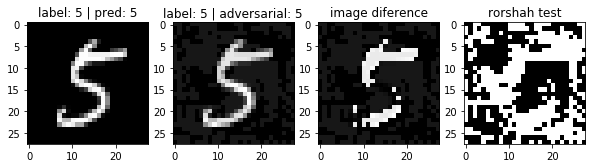

In [0]:
ce_loss = nn.CrossEntropyLoss()

fgsm_params = {'eps': 0.05}
loss_his, accuracy = test_on_adv(ibp_model, test_loader, ce_loss, fgsm_params, method='fgsm', verbose=False, ismean=True)
loss_his, accuracy = test_on_adv(ibp_model, vis_loader, ce_loss, fgsm_params, method='fgsm', verbose=False, ismean=False, isplot=True)

### Appendix

In [0]:
L_spec_hist = []
L_fit_hist = []

ibp_model.train()
for epoch in range(epochs):
    
    print('epoch:', epoch+1)
    N = 0
    for imgs, labels in train_loader:
        N += 1

        logits = ibp_model(imgs.cuda())
        predictions = (logits.data.max(1)[1]).detach().cpu()
        bounds = compute_bounds(ibp_model, imgs.cuda())
        z_k = bounds[-1]


        train_loss, L_spec, L_fit = ibp_loss(base_loss, logits, z_k, labels.cuda())
        train_loss.backward()

        ibp_opt.step()
        ibp_opt.zero_grad()

        ibp_train_hist.append(train_loss.detach().cpu().item())
        ibp_train_accuracy.append(np.mean((predictions == labels).numpy()))
        
        L_spec_hist.append(L_spec.detach().cpu().item())
        L_fit_hist.append(L_fit.detach().cpu().item())
        

    if verbose:
        print('training   loss: {:.2f} | accuracy: {:.2f}%'.format(np.mean(ibp_train_hist[-1-N:-1]),
                                                                       np.mean(ibp_train_accuracy[-1-N:-1]) * 100))
        
        print('L_spec: {:.2f} | L_fit: {:.2f}'.format(np.mean(L_spec_hist[-1-N:-1]), np.mean(L_fit_hist[-1-N:-1])) )

In [0]:
# # IBP
# class IBPNet(Net):
    
#     def __init__(self, eps):
#         super(IBPNet, self).__init__()
        
#         self.eps = eps
        
        
# #         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
# #         self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        
# #         self.flat = Flatten()
        
# #         self.fc1 = nn.Linear(784, 512)
# #         self.fc2 = nn.Linear(512, 128)
# #         self.fc3 = nn.Linear(128, 10)
        
# #         self.relu = nn.ReLU()
# #         self.mpool = nn.MaxPool2d(2)
# #         self.softmax = nn.Softmax(dim=1)
# #         self.logsoftmax = nn.LogSoftmax(dim=1)
        
# #         self.layers = nn.Sequential(
# # #             self.conv1,
# # #             self.relu,
# # #             self.mpool,
# # #             self.conv2,
# # #             self.relu,
# # #             self.mpool,
            
# #             self.flat,
# #             self.fc1,
# #             self.relu,
# #             self.fc2,
# #             self.relu,
# #             self.fc3
# # #             self.softmax
# #         )
        
# #     def bounds(self, x):
        
# #         z0_low = x - eps
# #         z0_up = x + eps
        
# #         for layer in 
        
        
       
        
        
    
# #     def forward(self, x):


In [0]:
# def adversaries(x, y, loss, model, eps):
    
#     req_grad(model, state=False)
#     x.requires_grad_(True)
    
#     logits = model(x.cuda())
#     loss_val = loss(logits, y.cuda())
#     loss_val.backward()
    
#     x_perturb = x + eps * torhch.sign(x.grad)
    
#     x.requires_grad_(False)
#     req_grad(model, state=True)
    
#     return x_perturb


# def perturb(x, y, model, loss):
#     req_grad(model, state=False)
#     x.requires_grad = True
    
#     logits = model(x.cuda(), y.cuda())
#     preds = (logits.data.max(1)[1]).detach().cpu()
    
#     loss_val = loss(logits, y.cuda())
#     loss_val.backward()
    
#     x_pert = x + eps * torch.sign(x.grad)
    
#     logits_pert = model(x_pert.cuda()) # approach 1 
#     x_pert = (x_pert - x_pert.min())/(x_pert.max() - x_pert.min())
# #     logits_pert = model(x_pert.cuda()) # approach 2
#     preds_pert = (logits_pert.data.max(1)[1]).detach().cpu()
        